<a id="2"></a>
# <p style="background-color:#092327;font-family:newtimeroman;color:#fbfffe;font-size:150%;text-align:center;border-radius:10px 10px; padding:20px;">Detecting and Classifying Electrical Faults</p>

The transmission of electrical power is an area that the majority of us take for granted, however due to the highly complex nature of power systems, electrical faults are always a looming threat. Particularly in countries such as Ireland and the UK, which are rapidly incorporating an increasing amount of non-synchronous wind power onto their grids.
To avoid serious consequences from system imbalances or failures, such as the dreaded “blackout”, competent fault detection systems are essential. These would ideally detect and correctly classify any faults that arise rapidly. As such, accuracy and model efficiency should be a primary focus. Machine Learning could serve as a tool to achieve greater understanding of a power system and classify faults.
The dataset being used contains information on currents and voltages in three phases, for different fault conditions. This data was generated through simulation.

## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px;">Table of Contents</p>


* [Importing Python libraries](#libraries)
* [Loading & Cleaning Data](#load)
* [Exploratory Data Analysis](#EDA)
* [Pre-Processing Data](#pre)
* [Baseline Modelling](#baseline)
* [Performance Evaluation](#eval)
* [Conclusion](#conc)
* [Future Improvements](#future)


## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;">Importing Python Libraries</p>  <a id=”libraries″></a>

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_recall_fscore_support
from statistics import mean, stdev
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;">Loading and Cleaning Data</p>  <a id=”load″></a>


In [34]:
coreFolder = "C:/Users/niall/Downloads/Electric_Fault_Data/"
data = pd.read_csv(coreFolder + "classData.csv")
data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [36]:
data.isna().sum()

G     0
C     0
B     0
A     0
Ia    0
Ib    0
Ic    0
Va    0
Vb    0
Vc    0
dtype: int64

In [37]:
data.duplicated().sum()

0

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'> About Dataset:</font></h3>

<ul>
    <li>The dataset contains 7861 rows and 10 columns.</li>
    <li>There are no empty cells or repeated rows.</li>
    <li>All data points are numeric.</li>
    <li>The first 4 columns of the dataset indicate whether the Ground, Phase C, Phase B and Phase A (respectively) are involved in the fault.</li>
    <ul> <li> These 4 columns can be combined to create 6 different fault classes.</li> </ul>
    
</ul>

A link to the dataset is available **[here.](https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification/data)**

</div>



<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'> About Features:</font></h3>

The original dataset contains 6 inputs and 4 outputs.
<ul>
    <li> The inputs are the current and voltage through each of the three phases. </li>
    <li> A combination of the 4 outputs can be used to determine the type of fault</li>    
</ul>

To easily classify the fault sources, I will transform the 4 output variables into a single output variable.
</div>



In [38]:
faults = {
    (0,0,0,0):"No Fault" , 
    (1,0,0,1):"LG fault " , 
    (0,0,1,1):"LL fault " , 
    (1,0,1,1):"LLG Fault " , 
    (0,1,1,1):"LLL Fault" , 
    (1,1,1,1):"LLLG fault"  
}

In [39]:
def get_fault(row):
    return faults.get(tuple(row), "Unknown Fault")

data.loc[:,'FaultType'] = data.apply(lambda row: get_fault(row[['G', 'C', 'B', 'A']]), axis=1)
data.drop(columns = ['G','C','B','A'], axis=1, inplace=True)

data.head()

,Ia,Ib,Ic,Va,Vb,Vc,FaultType
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,LG fault
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,LG fault
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,LG fault
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,LG fault
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,LG fault


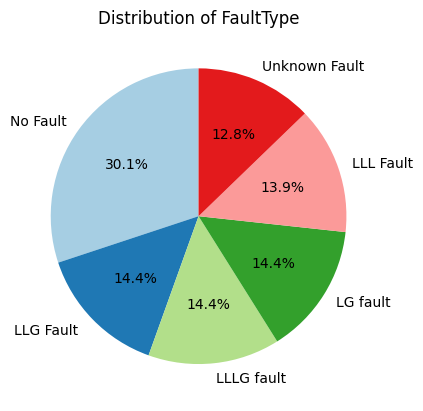

In [40]:
# Visualizing the distributino of the target variable
target = data.columns[-1]
counts = data[target].value_counts()
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title(f'Distribution of {target}')
plt.show()

* While there is a greater number of 'No Fault' instances, there is a similar distribution between the other fault types. This is important for multi-class problems to avoid bias and low generalization in machine learning.

Encoding the categorical FaultType column to allow for classification

In [41]:
label_encoder = LabelEncoder()
data['FaultType']= label_encoder.fit_transform(data['FaultType'])
data.head()

,Ia,Ib,Ic,Va,Vb,Vc,FaultType
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,0
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,0
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,0
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,0
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,0


## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;"> Exploratory Data Analysis (EDA)  </p>  <a id=”EDA″></a>


In [42]:
data.describe()

,Ia,Ib,Ic,Va,Vb,Vc,FaultType
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515,2.697494
std,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897,1.652150
min,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709,0.000000
25%,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977,1.000000
50%,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281,3.000000
75%,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973,4.000000
max,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179,5.000000


* The difference between the mean and min/max values of current show that there are some extreme outliers in the data.
* Voltage means are close to zero, with ranges roughly between -0.6 and +0.6
* The standard deviations of the voltages are much lower than the currents, which suggests that the voltage has greater stability.
* High standard deviation values in current values are to be expected since electrical faults often result in current deviations.

### Analyzing the relationship between the input variables

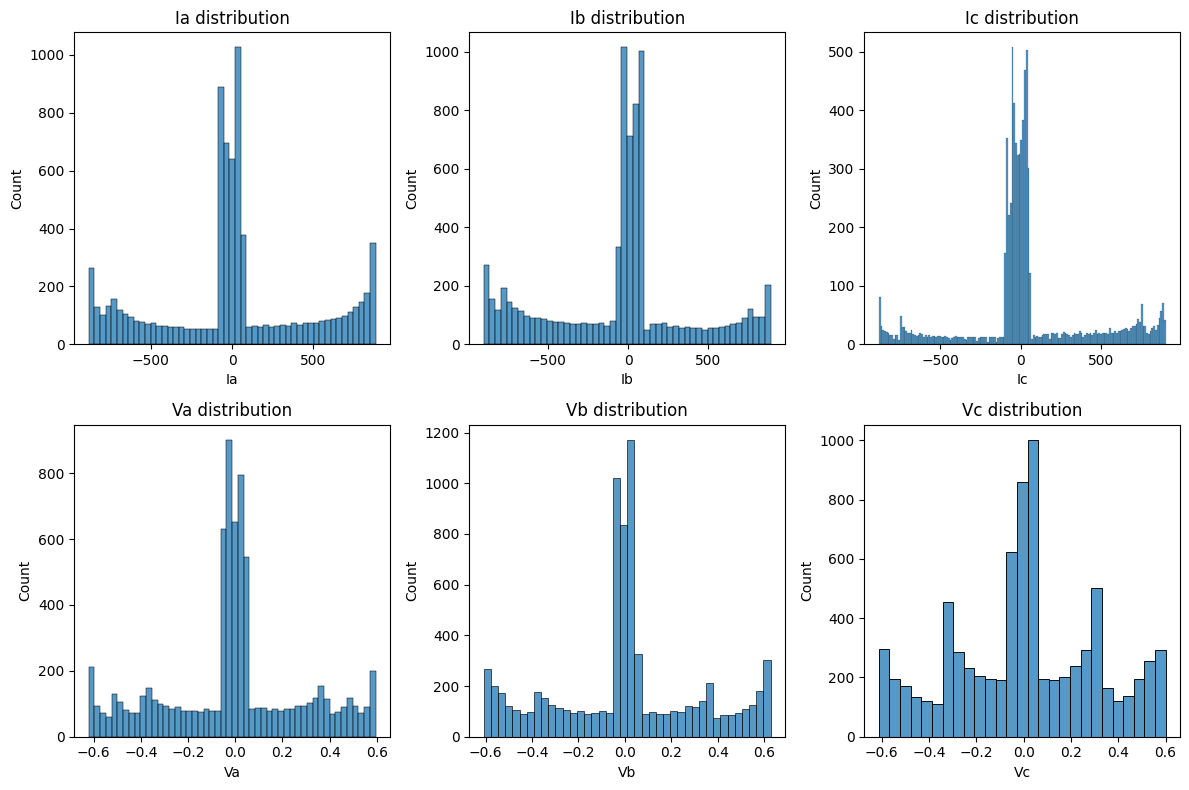

In [43]:
features = data.columns[:-1]
plt.figure(figsize=(12,8))
i = 0
for feature  in features:
    plt.subplot(2,3,i+1)
    sns.histplot(data[feature])
    plt.title(f"{feature} distribution")
    i+=1
plt.tight_layout()
plt.show()

* The above plot shows the relationship between the current and voltages in each line.
* Both current and voltage readings appear to vary, however voltage readings have a narrower distribution around 0.

### Visualizing the correlation between the variables

<Axes: >

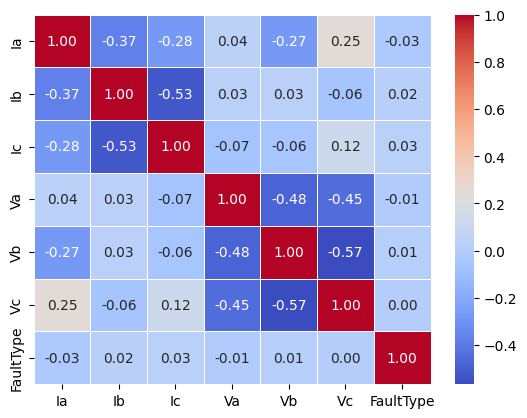

In [44]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidth=.5)


* Is appears that while there is only a moderate correlation between some variables, which should be of no major concern.
* The moderate negative correlations shows that a rise of voltage and current in one line leads to a drop in another line.
* This is typical of electrical systems, and also re-enforces the value of correlation analysis in understanding complex systems.

### Looking at distributions and checking for outliers

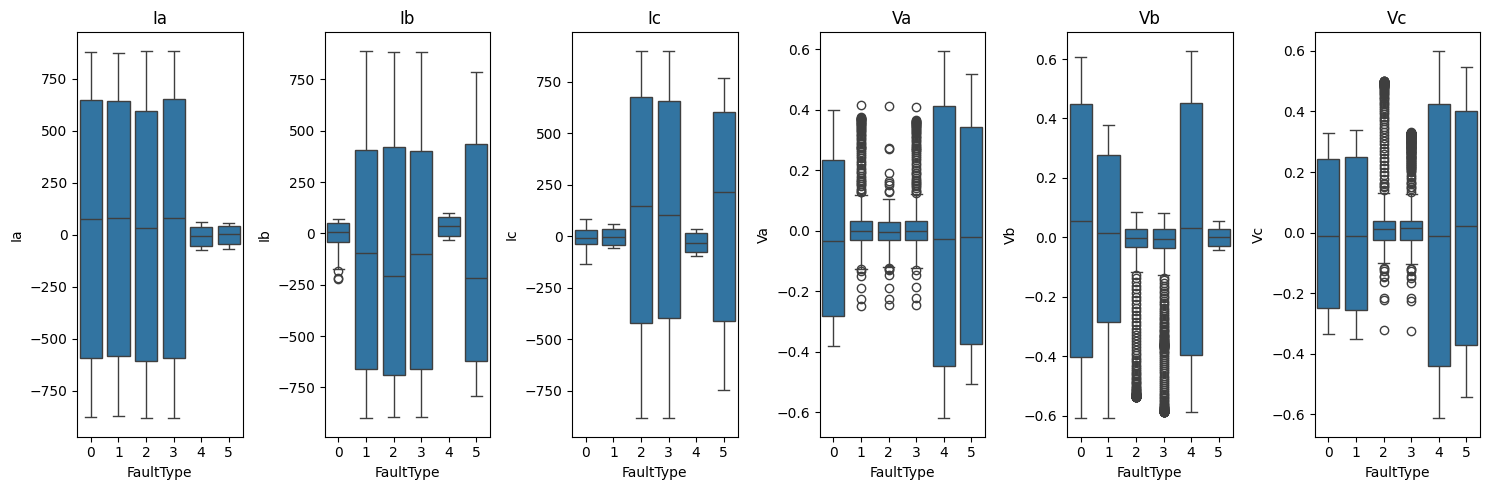

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=len(data.columns[0:-1]), figsize=(15, 5))
# Create boxplots for each variable in the specified subplot
for i, variable in enumerate(data.columns[0:-1]):
    sns.boxplot(x="FaultType", y=variable, data=data, ax=axes[i], whis = 1.5)
    axes[i].set_title(f"{variable}")

plt.tight_layout()
plt.show()


* These boxplots indicate the presence of outliers in the voltage readings. 
* It appears that these outliers only exist with certain fault types.
* Note that the boxplot function classifies outliers as values that deviate outside the upper or lower quartiles by 1.5*IQR 

## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;"> Pre-Processing Data  </p>  <a id=”pre″></a>

In this dataset, the range of current and voltage data lie in different orders of magnitude. This could negatively affect the performance of certain models, making certain features dominant or at least slowing down convergence.

For simplicity, I will normalize the features using a standard scaler before modelling. The standard scaler transforms the data such that it has a mean of 0 and standard deviation of 1. Personal experimentation has found that using a min-max scaler resulted in low accuracy.

In [46]:
X = data.iloc[:,0:-1]
Y = data.iloc[:,-1]

scaler= StandardScaler()
X_norm = scaler.fit_transform(X)


## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;"> Baseline Modelling </p>  <a id=”baseline″></a>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'> Baseline Modelling Strategy:</font></h3>

**As this is a multi-class rather than binary classification problem, some areas that require further attention are:**
* **Class imbalance:** A reasonable distribution of classes is required to ensure reliability. If there is a significant imbalance, methods such as using class weights should be used.
* **Cross Validation:** With multi-class problems, stratified k-fold cross validation  preserves the percentage of samples for each class.
* **Model Selection:** If a model cannot handle multi class classification, one vs all or one vs one strategies would have to be used. **K-nearest neighbours, Decision Trees, Random Forests, Naive-Bayes and Gradient** boosting algorithms such as **XGBoost** are some of the most common classifiers used for multi class problems and are used in this project.

**Performance metrics used:**
* **Accuracy:** This is the ratio of correctly classified instances to the total number.
* **ROC-AUC score:** This is the area under the curve of the ROC curve. A high AUC score shows that the classifier distinguishes well between different classes. A model with a value of 1.0 generates no false positives. To deal with multi class data, the "One vs Rest" strategy is used.
* **Precision:** This is the ratio of true positive predictions to the total number of positive predictions. 
* **Recall:** This is the ratio of the true positive predictions to the total number of actual positive instances. For both precision and recall, weighted averaging is used. This means that the values for each class are separately determined and the average is taken. 
* **Confusion Matrix:** This matrix allows incorrectly classified instances to be easily identified.


I will also calculate feature importances to see whether any redundant features exist. Feature importance scores effectively show how useful each feature is at predicting a target variable. Each model likely has a unique method of determining feature importance scores.


In [47]:
def createModels():
  xg = xgb.XGBClassifier()
  knn = KNeighborsClassifier()
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  nb = GaussianNB()
  return ((xg,"XGBoost Classifier"),(knn,"KNN Classifier"),(dt,"Decision Tree Classifier"),
          (rf,"Random Forest Classifier"), (nb,"Naive Bayes Classifier"))



**Steps**
* Instantiating stratified k-fold cross validation.
* Creating empty arrays to store results.
* Looping over each model and each CV fold.
* Splitting normalized data into training and testing.
* Fitting the model on the training data and generating predictions on the test data.
* Evaluating each models performance and storing results in the variables. Final results are an average of the results from each fold.

In [48]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
models = createModels()

modelAcc = []
modelCm = []
modelAuc = []
modelPrec = []
modelRec = []
modelImp = []

for model, name in models:
    foldAcc = []
    foldAuc = []
    foldCm = []
    foldPrec = []
    foldRec = []
    foldImp = []

    for train_index, test_index in skf.split(X_norm, Y):
        x_train_fold, x_test_fold = X_norm[train_index], X_norm[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]
        model.fit(x_train_fold, y_train_fold)
        y_pred_prob_fold = model.predict_proba(x_test_fold)
        y_pred_fold = model.predict(x_test_fold)

        #Evaluating
        foldAcc.append(model.score(x_test_fold, y_test_fold))
        y_pred_prob_fold = model.predict_proba(x_test_fold)
        y_pred_fold = model.predict(x_test_fold)
        foldAuc.append(roc_auc_score(y_test_fold, y_pred_prob_fold,multi_class='ovr' ))
        foldCm.append(confusion_matrix(y_test_fold, y_pred_fold))
        precision, recall, _, _ = precision_recall_fscore_support(y_test_fold, y_pred_fold, average='weighted')
        foldPrec.append(precision)
        foldRec.append(recall)
        if hasattr(model, 'feature_importances_'):
            foldImp.append(model.feature_importances_)
            
    modelAcc.append(mean(foldAcc))
    modelCm.append(sum(foldCm)/len(foldCm))
    modelAuc.append(mean(foldAuc))
    modelPrec.append(mean(foldPrec))
    modelRec.append(mean(foldRec))
    if hasattr(model, 'feature_importances_'):
        modelImp.append(sum(foldImp)/len(foldImp))  
    else: # to avoid division by zero
        modelImp.append(foldImp)
    


## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;"> Performance Evaluation  </p>  <a id=”eval″></a>

In [49]:
df = pd.DataFrame([modelAcc, modelAuc, modelPrec, modelRec])
df.rename(columns={0: 'XGboost',1: 'KNN Classifier',2: 'Decision Tree',3: 'Random Forest',4: 'Naive Bayes'}, inplace=True)
df.rename(index={0: 'Accuracy',1: 'AUC Score',2: 'Precision',3: 'Recall'}, inplace=True)


In [50]:
df

,XGboost,KNN Classifier,Decision Tree,Random Forest,Naive Bayes
Accuracy,0.811983,0.799898,0.873807,0.870627,0.793412
AUC Score,0.965118,0.963112,0.913725,0.971168,0.956151
Precision,0.811511,0.797016,0.874124,0.870758,0.773447
Recall,0.811983,0.799898,0.873807,0.870627,0.793412


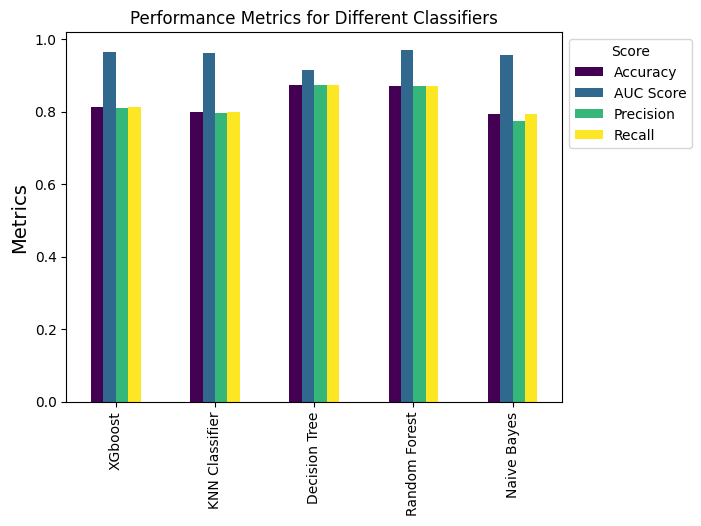

In [51]:

ax = df.T.plot(kind='bar', colormap='viridis')
ax.set_ylabel('Metrics', fontsize=14)
ax.set_title('Performance Metrics for Different Classifiers')
plt.legend(title='Score', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

* From the above chart, it seems that Decision Trees and Random Forest classifiers perform the best based on the performance metrics that were used.
* Although the Random Forest model had slightly lower values of Accuracy, Precision and Recall when compared to the Decision Tree model, its ROC-AUC score was noticeably higher. 

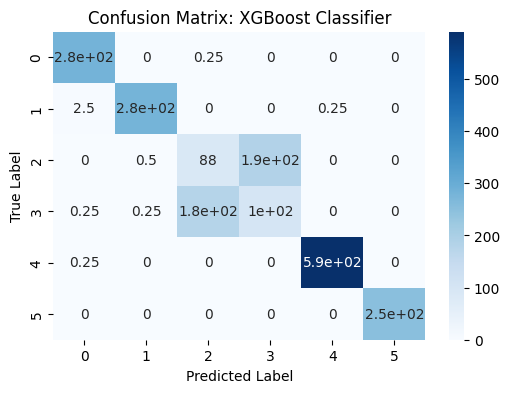

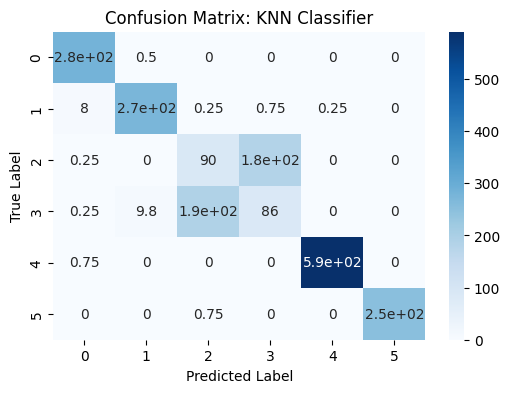

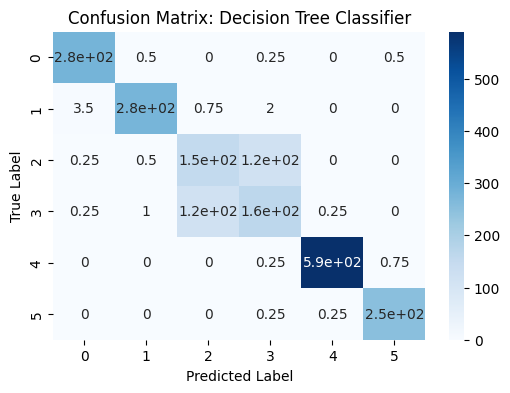

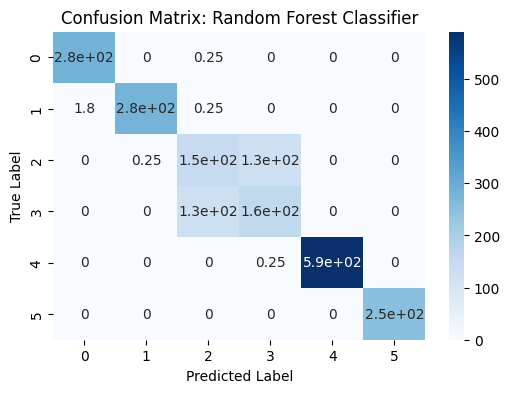

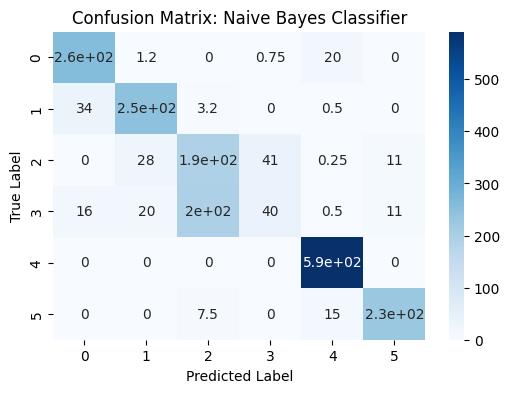

In [52]:
i = 0
for model, name in models:
    plt.figure(figsize=(6, 4))
    sns.heatmap(modelCm[i], annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: '+name)
    plt.show()
    
    i+=1

KNN Classifier has no feature importance attribute.
Naive Bayes Classifier has no feature importance attribute.


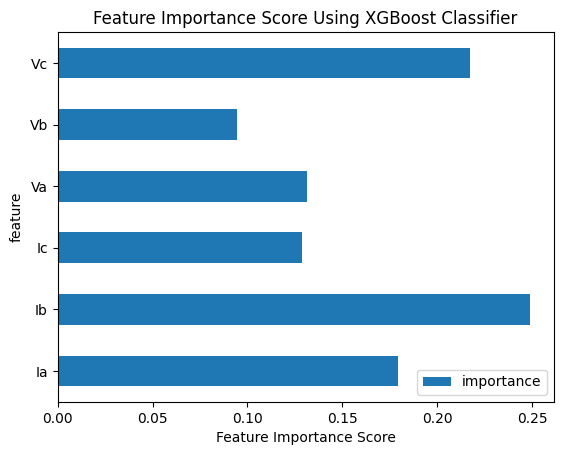

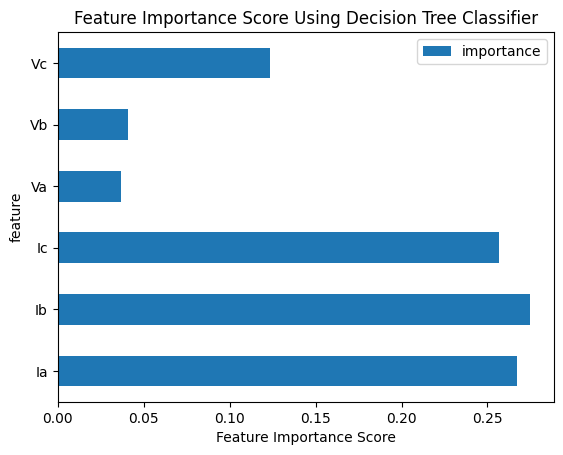

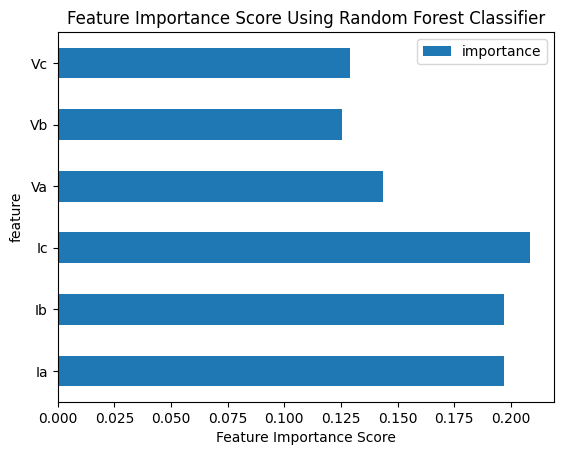

In [53]:
i = 0
features = np.concatenate([data.columns[0:-1]])
for model,name in models:
    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.DataFrame({'importance':modelImp[i]})    
        feat_imp['feature'] = features
        feat_imp = feat_imp.set_index('feature', drop=True)
        feat_imp.plot.barh(title=f"Feature Importance Score Using {name}")
        plt.xlabel('Feature Importance Score')
    else:
        print(f"{name} has no feature importance attribute.")
    i+=1
plt.show()

* There is a noticeable amount of variation in the feature importance scores between models. This is to be expected as the models may use different methods and use different measures to determine the score.
* The majority of the models associate more importance to the currents rather than voltages, although the feature importance scores themselves vary.
* This suggests that perhaps ombining predictions from each of these models using ensembles would improve accuracy.

## <p style="background-color:#0b5351;font-family:newtimeroman;color:#fbfffe;font-size:125%;text-align:center;border-radius:10px 10px; padding:20px; margin:0;"> Conclusions  </p>  <a id=”conc″></a>

* The data set used was of reasonably high quality, in that there were no empty cells and repeated rows. However, there were some outliers present.
* There is a reasonably equal distribution between the fault types, aside from the "No Fault" type, which is more than twice as prominent than others.
* Current data showed a high standard deviation.
* There was a moderate negative correlation between the current and voltage in different lines.
* The highest performing model, was able to predict the fault type in the transmission line with 87.8% accuracy.
* Tree based models performed the best, while KNN and Naive Bayes classifiers performed the worst.
  
